In [33]:
import os, pickle, time, torch, cv2, random, shutil
import smpgit.segmentation_models_pytorch as smp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as albu
from utils import *
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

# Plots of Metrics

In [30]:
def get_metrics(fn):
    with open(fn, 'r') as f:
        lines = f.readlines()
    
    collects = []
    for l in lines:
        if 'dice_loss' in l or 'iour_score' in l or ']\n' in l:
            collects.append(l)
    
    collects2 = []
    for l in collects:
        l1 = l.split('\n')[0]
        lst = l1.split(',')
        for x in lst:
            if 'dice_loss' in x or 'iou_score' in x or 'precision' in x or 'ision - ' in x or ']\n' in x:
                collects2.append(x)
    
    d = {
        'dice_loss': [],
        'iou_score': [],
        'precision': []
    }

    for l in collects2:
        x = l.split(' - ')[-1].replace(']', '')
        if 'dice_loss' in l:
            d['dice_loss'].append(float(x))
        elif 'iou_score' in l:
            d['iou_score'].append(float(x))
        elif 'ision - ' in l:
            d['precision'].append(float(x))
    
    for k, v in d.items():
        print(len(v), end=' ')
    
    return d

In [58]:
def plot_metrics_single(d, k):
    if k == 'prediction':
        k = k.capitalize()
    plt.plot(d[k][::2], label='Train')
    plt.plot(d[k][1::2], label='Val')
    plt.title('Curve of '+k)
    plt.xlabel('Epoch')
    plt.ylabel(k)
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

In [61]:
d_densenet121 = get_metrics('./output/densenet-121.txt')
d_effb4 = get_metrics('./output/efficientnet-b4.txt')
d_effb7 = get_metrics('./output/efficientnet-b7.txt')

61 61 60 60 60 56 61 61 61 

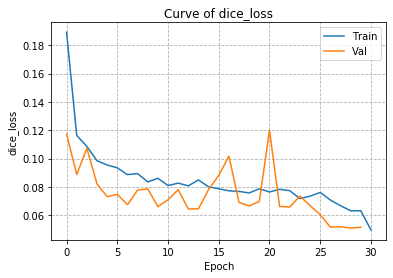

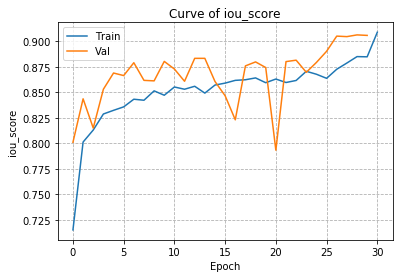

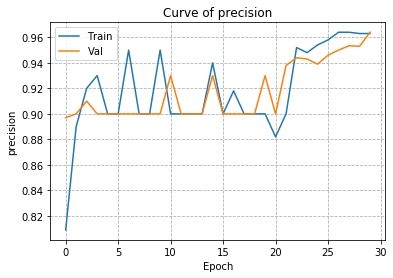

In [64]:
for k in d_densenet121.keys():
    plot_metrics_single(d_densenet121, k)

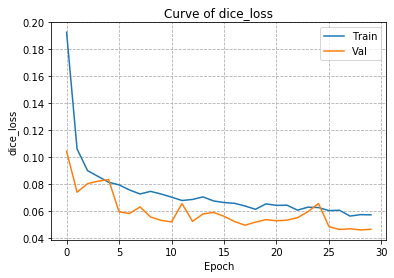

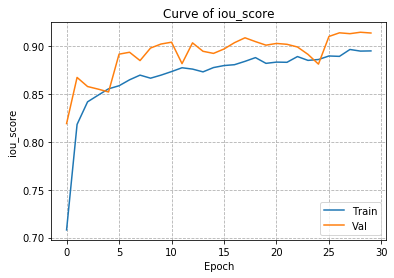

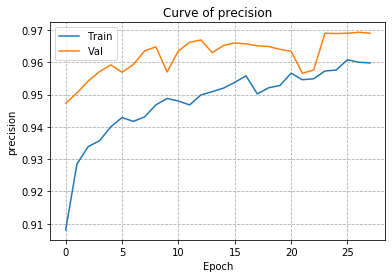

In [62]:
for k in d_effb4.keys():
    plot_metrics_single(d_effb4, k)

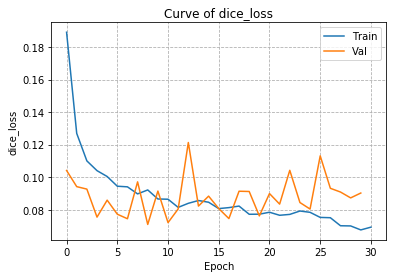

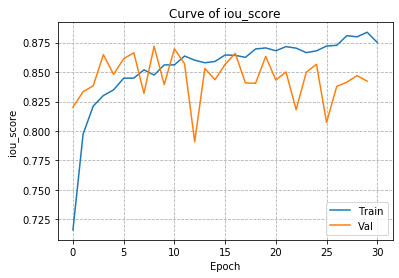

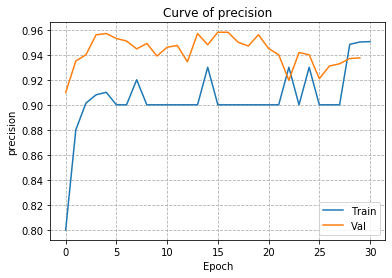

In [63]:
for k in d_effb7.keys():
    plot_metrics_single(d_effb7, k)

# Visualization of Predictions

In [70]:
#ENCODER = 'se_resnext50_32x4d'
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ["void", "road", "lanemarks", "curb", "person", "rider",
           "vehicles", "bicycle","motorcycle", "traffic_sign"]
#ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multicalss segmentation
ACTIVATION = 'sigmoid'
DEVICE = 'cuda:1'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [71]:
PATH_x = './rgb_images/'
PATH_y = './WoodScape_ICCV19/semantic_annotations/semantic_annotations/gtLabels/'
fns_x = os.listdir(PATH_x)
fns_y = os.listdir(PATH_y)
fns_x.sort()
fns_y.sort()

In [78]:
# load best saved checkpoint
best_model = torch.load('./output/16-02-58-45efficientnet-b4_bs=8_epochs=30/best_model.pth')

In [94]:
dataset_nonarg_tr = Dataset(PATH_x + 'tr/', PATH_y + 'tr/', classes=CLASSES)

dataset_tr = Dataset(
    PATH_x + 'tr/', PATH_y + 'tr/', classes=CLASSES,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

dataset_va = Dataset(
    PATH_x + 'va/', PATH_y + 'va/', classes=CLASSES,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

dataset_te = Dataset(
    PATH_x + 'te/', PATH_y + 'te/', classes=CLASSES,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

PATH = './rgb_images(test_set)'
dataset_test_no = Dataset(
    PATH, None, classes=CLASSES,
)

PATH = './rgb_images(test_set)'
dataset_test = Dataset(
    PATH, None, classes=CLASSES,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing_no_mask(preprocessing_fn)
)

In [95]:
loader_tr = DataLoader(dataset_tr, batch_size=8, num_workers=12)
loader_va = DataLoader(dataset_va, batch_size=1, num_workers=4)
loader_te = DataLoader(dataset_te, batch_size=1, num_workers=4)
loader_test = DataLoader(dataset_test, batch_size=1, num_workers=4)

In [100]:
best_model.eval()
with tqdm(loader_test, desc='Output Prediction', file=sys.stdout, disable=False) as iterator:
    for x in dataset_test:
        print(x.shape)
        x = torch.tensor(x.reshape((1, 3, 966, 1280)))
        x = x.to('cuda')
        print(x.shape)
        pr_mask = best_model.predict(x)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        print(pr_mask.shape)
        break

Output Prediction:   0%|          | 0/1766 [00:00<?, ?it/s](3, 966, 1280)
torch.Size([1, 3, 966, 1280])
(10, 960, 1280)
Output Prediction:   0%|          | 0/1766 [00:00<?, ?it/s]


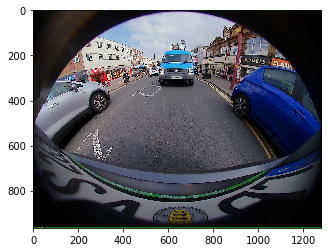

In [166]:
i = random.choice(range(1766))
plt.imshow(dataset_test_no[i])

torch.Size([1, 3, 966, 1280])
(10, 960, 1280)


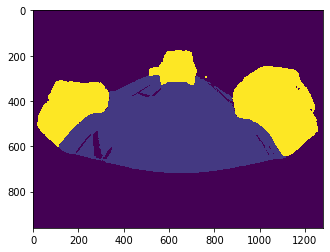

In [167]:
x = dataset_test[i]
x = torch.tensor(x.reshape((1, 3, 966, 1280)))
x = x.to('cuda')
print(x.shape)
pr_mask = best_model.predict(x)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())
print(pr_mask.shape)
img = pr_mask.argmax(axis=0)
plt.imshow(img)

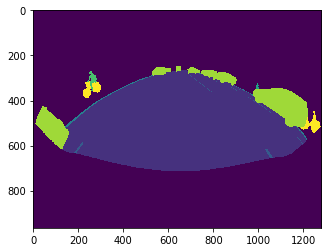

In [120]:
plt.imshow(img.mean(axis=2))

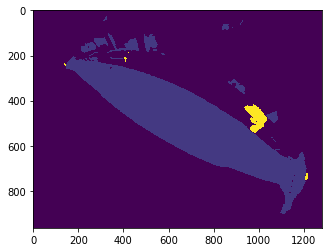

In [95]:
plt.imshow(img)

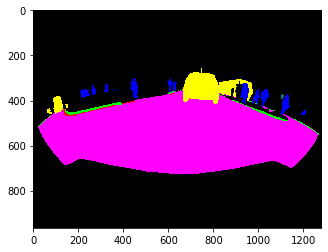

In [10]:
plt.imshow(img)

In [30]:
best_model.eval()
with tqdm(loader_test, desc='Output Prediction', file=sys.stdout, disable=False) as iterator:
    for i, x in enumerate(iterator):
        x = x.to(DEVICE)
        pr_mask = best_model.predict(x)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        pr_mask = pr_mask.argmax(axis=0)
        pr_mask = cv2.copyMakeBorder(pr_mask, 1, 1, 0, 0, cv2.BORDER_REPLICATE)
        pr_mask = np.array([pr_mask]*3)
        pr_mask = pr_mask.reshape((pr_mask.shape[1], pr_mask.shape[2], 3))
        fn = os.path.join(savePATH, dataset_test.ids[i])
        cv2.imwrite(fn, pr_mask)

Output Prediction: 100%|██████████| 1766/1766 [04:11<00:00,  7.02it/s]
